In [1]:
! pip -q install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00


In [2]:
import os
import json
import warnings
import cv2

import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
from torch.serialization import add_safe_globals
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from segmentation_models_pytorch.decoders.unetplusplus.model import UnetPlusPlus

from PIL import Image
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class CariesDataset(Dataset):
    def __init__(self, images_path_list, labels_path_list, augmentation = True, device = 'cpu', image_size = (384, 768)):
        self.images = images_path_list
        self.labels = labels_path_list
        self.augmentation = augmentation
        self.device = device

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

        if self.augmentation:
            self.same_augmentation = transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.RandomHorizontalFlip(p = 0.5)
            ])

            self.different_augmentation = transforms.Compose([
                transforms.RandomAdjustSharpness(2),
                transforms.ColorJitter(brightness=0.5, contrast=0.5)
            ])


    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = Image.open(self.labels[idx])

        if self.augmentation:
            seed = np.random.randint(0, 10000)

            torch.random.manual_seed(seed)
            image = self.same_augmentation(image)
            image = self.different_augmentation(image)

            torch.random.manual_seed(seed)
            label = self.same_augmentation(label)

        image = self.transform(image).to(self.device)
        label = self.transform(label).to(self.device)

        label = 1. * (label != 0)

        return image, label

    def __len__(self):
        return len(self.images)

In [12]:
image_path ='/content/drive/MyDrive/Диплом/dataset/images_cut'
labels_path = '/content/drive/MyDrive/Диплом/dataset/labels_cut'

file_names = [filename for filename in os.listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)


train_image_path = [os.path.join(image_path, file_name) for file_name in train_files]
train_mask_path = [os.path.join(labels_path, file_name) for file_name in train_files]

eval_image_path = [os.path.join(image_path, file_name) for file_name in val_files]
eval_mask_path = [os.path.join(labels_path, file_name) for file_name in val_files]

print(f"Количество изображений в обучающей выборке: {len(train_files)}")
print(f"Количество изображений в валидационной выборке: {len(val_files)}")

Количество изображений в обучающей выборке: 80
Количество изображений в валидационной выборке: 20


In [ ]:
train_dataset = CariesDataset(
    images_path_list = train_image_path,
    labels_path_list = train_mask_path,
    augmentation = True,
    device = device,
)

eval_dataset = CariesDataset(
    images_path_list = eval_image_path,
    labels_path_list = eval_mask_path,
    augmentation = False,
    device = device,
)

toPIL = transforms.ToPILImage()

batch_size = 8

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, batch_size=1)

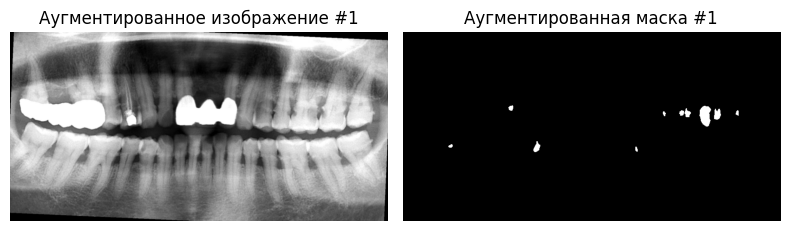

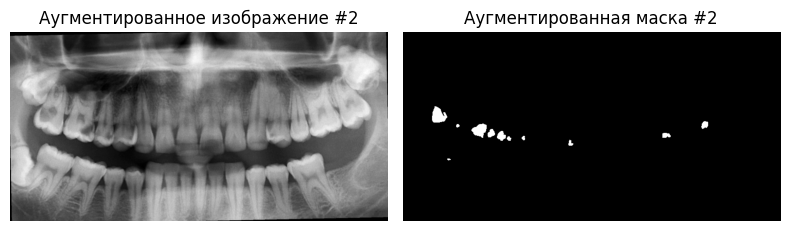

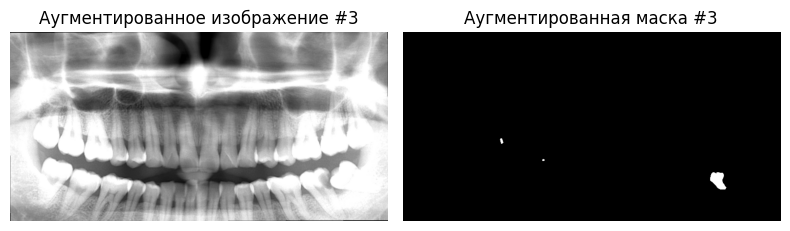

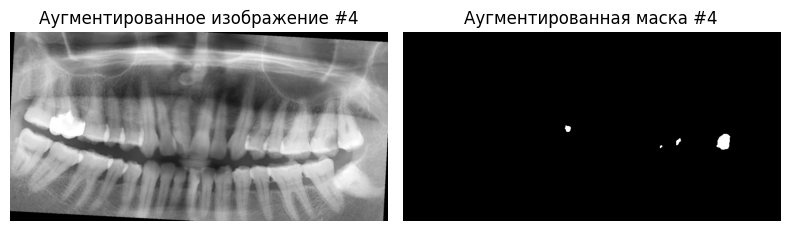

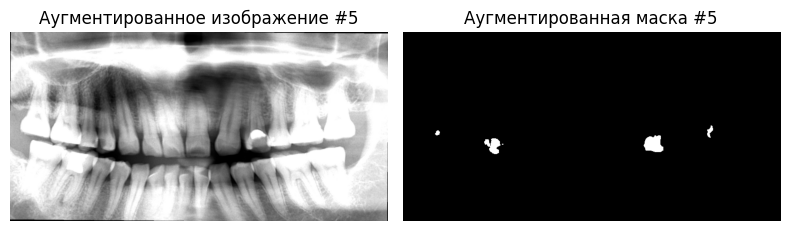

In [ ]:
indices = random.sample(range(len(train_dataset)), 5)

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]  # Получаем изображение и маску
    image_np = image.cpu().detach()  # Переводим на CPU, если нужно
    label_np = label.cpu().detach()

    # Визуализация
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(to_pil_image(image_np), cmap='gray')
    plt.title(f'Аугментированное изображение #{i+1}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(to_pil_image(label_np), cmap='gray')
    plt.title(f'Аугментированная маска #{i+1}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_augmentation(dataset, index):
    import copy

    # Получаем оригинальные пути
    image_path = dataset.images[index]
    label_path = dataset.labels[index]

    # Загружаем оригинальные изображения без трансформаций
    original_image = Image.open(image_path)
    original_mask = Image.open(label_path)

    # Применяем аугментации через датасет
    augmented_image, augmented_mask = dataset[index]

    # Переводим тензоры обратно в PIL
    augmented_image_pil = to_pil_image(augmented_image.cpu())
    augmented_mask_pil = to_pil_image(augmented_mask.cpu())

    # Визуализация
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Оригинальное изображение')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(original_mask, cmap='gray')
    plt.title('Оригинальная маска')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(augmented_image_pil, cmap='gray')
    plt.title('Аугментированное изображение')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(augmented_mask_pil, cmap='gray')
    plt.title('Аугментированная маска')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

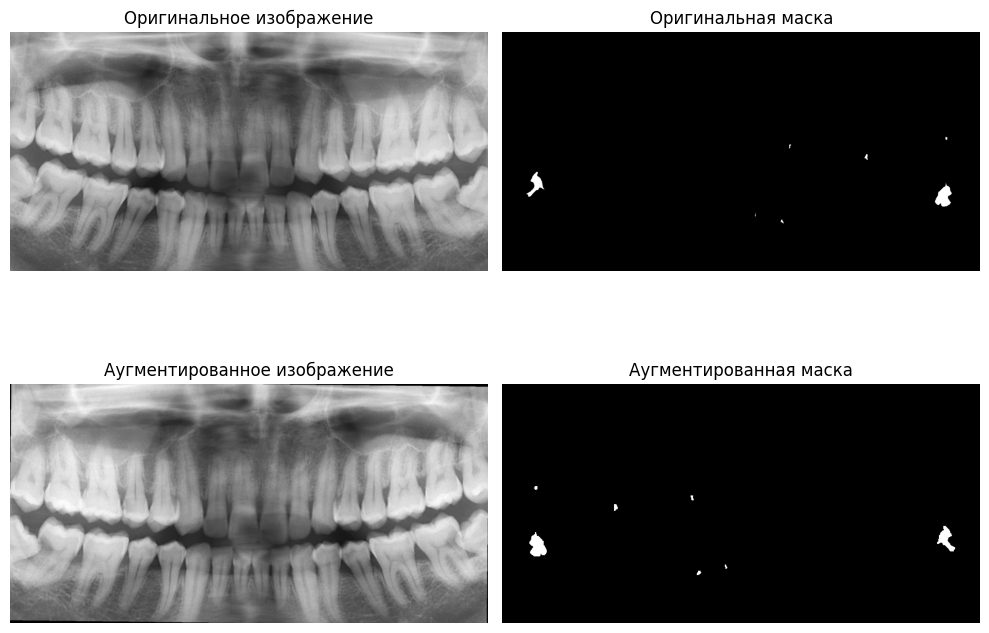

In [ ]:
visualize_augmentation(train_dataset, index=10)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth = 1, activation = None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.activation = activation

    def forward(self, inputs, targets):
        if self.activation:
            inputs = self.activation(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice



def metric_calculate(prediction: np.ndarray, target: np.ndarray):

    target = np.uint8(target.flatten() > 0.5)
    prediction = np.uint8(prediction.flatten() > 0.5)
    TP = (prediction * target).sum()
    FN = ((1 - prediction) * target).sum()
    TN = ((1 - prediction) * (1 - target)).sum()
    FP = (prediction * (1 - target)).sum()

    acc = (TP + TN) / (TP + TN + FP + FN + 1e-4)
    iou = TP / (TP + FP + FN + 1e-4)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-4)
    pre = TP / (TP + FP + 1e-4)
    spe = TN / (FP + TN + 1e-4)
    sen = TP / (TP + FN + 1e-4)

    return acc, iou, dice, pre, spe, sen

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name = 'efficientnet-b0',
    encoder_weights = 'imagenet',
    in_channels = 1,
    classes = 1,
).to(device)

model_name = 'UNetEfficientnetB0'

criterion = DiceLoss(activation=F.sigmoid)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_epoch = 50

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
print (f'Training {model_name} start.')

IoU_max = 0.
losses_train, losses_val = [], []
metrics = []

for epoch in tqdm(range(num_epoch)):
    current_train_loss, current_val_loss = 0., 0.
    current_metric = np.zeros(6)

    model.train()
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        current_train_loss += loss.item() / len(train_dataloader)

    model.eval()
    with torch.no_grad():
        for images, labels in eval_dataloader:
            logits = model(images)
            loss = criterion(logits, labels)

            current_val_loss += loss.item() / len(eval_dataloader)
            current_metric += np.array(metric_calculate(
                logits.cpu().detach().numpy(),
                labels.cpu().detach().numpy())) / len(eval_dataloader)

    losses_train.append(current_train_loss)
    losses_val.append(current_val_loss)
    metrics.append(current_metric.tolist())

    if IoU_max < metrics[-1][1]:
        torch.save(model, f'{model_name}-best.pth')
        IoU_max = metrics[-1][1]

    print (f'Epoch: {epoch + 1}, train_loss: {losses_train[-1]:.4f}, val_loss: {losses_val[-1]:.4f}, IoU: {metrics[-1][1]:.4f}')


log = {}
log['train_loss'] = losses_train
log['eval_loss'] = losses_val
log['metric'] = metrics
log['best_score'] = IoU_max

torch.save(model, f'{model_name}-last.pth')

with open(f'log.txt', 'w') as outfile:
    json.dump(log, outfile)

torch.cuda.empty_cache()

print ('- - ' * 30)
print (f'Training {model_name} done. Best IoU: {IoU_max:.4f}.')
print ('- - ' * 30)

Training UNetEfficientnetB0 start.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.1936, val_loss: 0.3238, IoU: 0.5369
Epoch: 2, train_loss: 0.1843, val_loss: 0.3056, IoU: 0.5567
Epoch: 3, train_loss: 0.1947, val_loss: 0.3085, IoU: 0.5552
Epoch: 4, train_loss: 0.1766, val_loss: 0.3127, IoU: 0.5475
Epoch: 5, train_loss: 0.1698, val_loss: 0.3078, IoU: 0.5521
Epoch: 6, train_loss: 0.1717, val_loss: 0.3067, IoU: 0.5551
Epoch: 7, train_loss: 0.1700, val_loss: 0.3201, IoU: 0.5429


KeyboardInterrupt: 

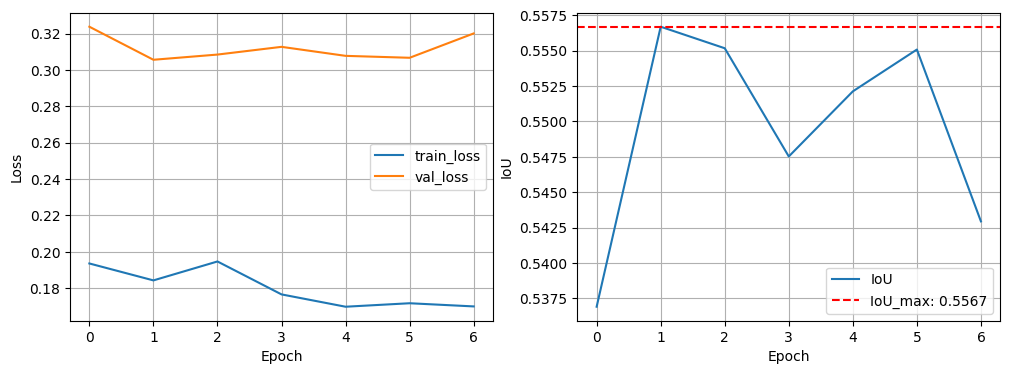

In [ ]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses_train, label = 'train_loss')
plt.plot(losses_val, label = 'val_loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot([metric[1] for metric in metrics], label = 'IoU')
plt.axhline (IoU_max, linestyle = '--', color = 'red', label = f'IoU_max: {IoU_max:.4f}')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('IoU')

plt.savefig('efficientnet-b0.png')
plt.show()


In [ ]:
add_safe_globals([UnetPlusPlus])
model = torch.load('UNetEfficientnetB0-best.pth', weights_only=False)
model.eval()
image, label = eval_dataset[6]
toPIL = transforms.ToPILImage()

In [ ]:
probabilities = F.sigmoid(model(image.unsqueeze(0))).squeeze(0)

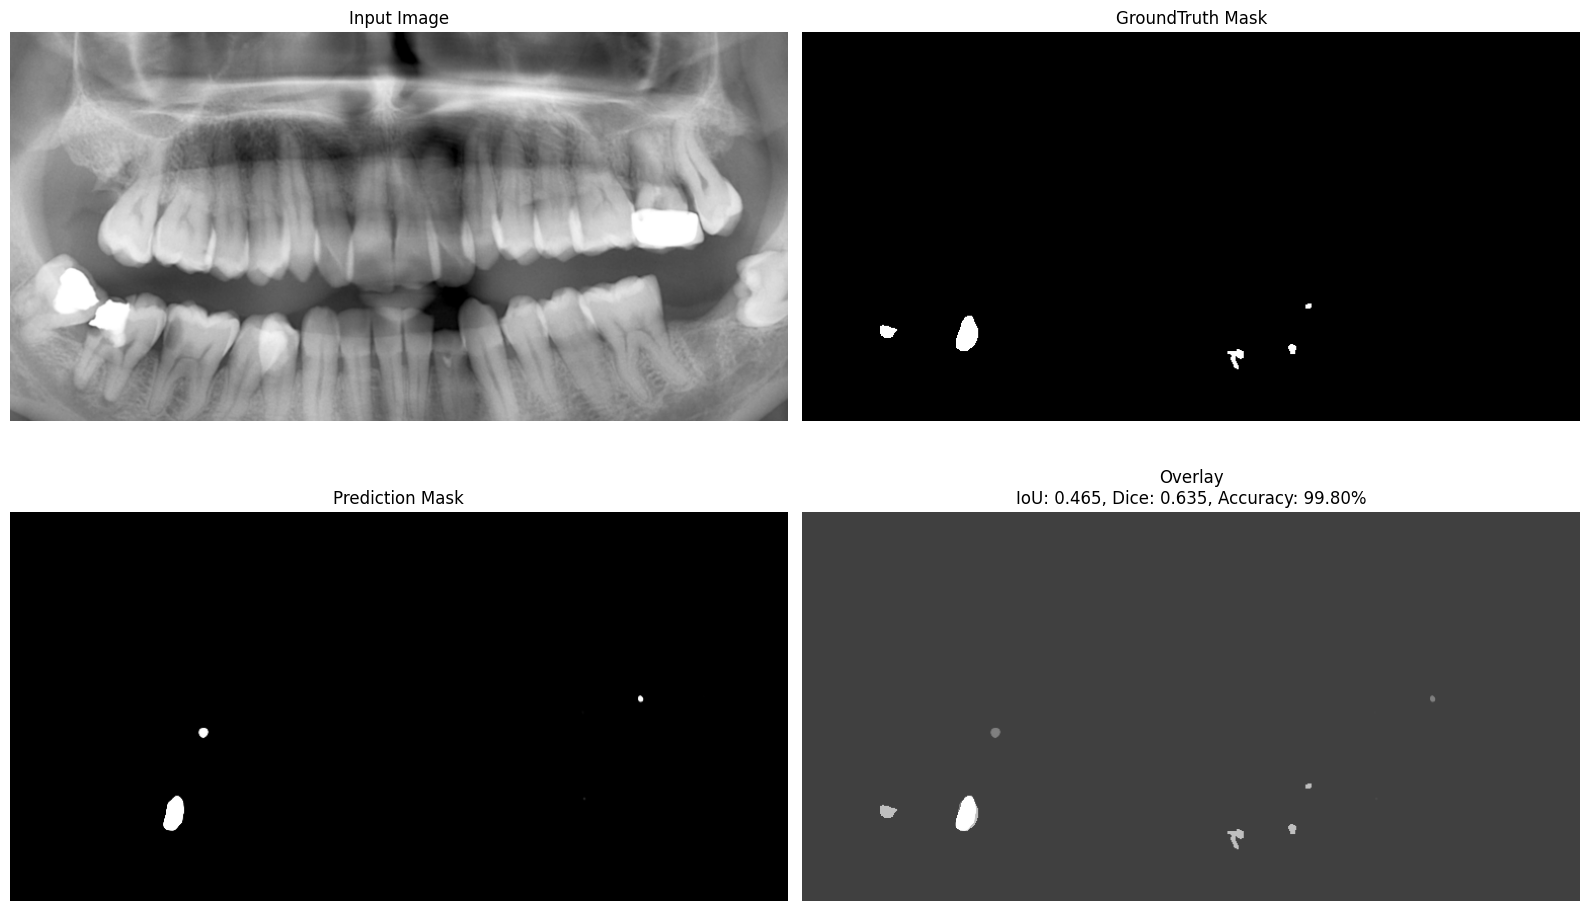

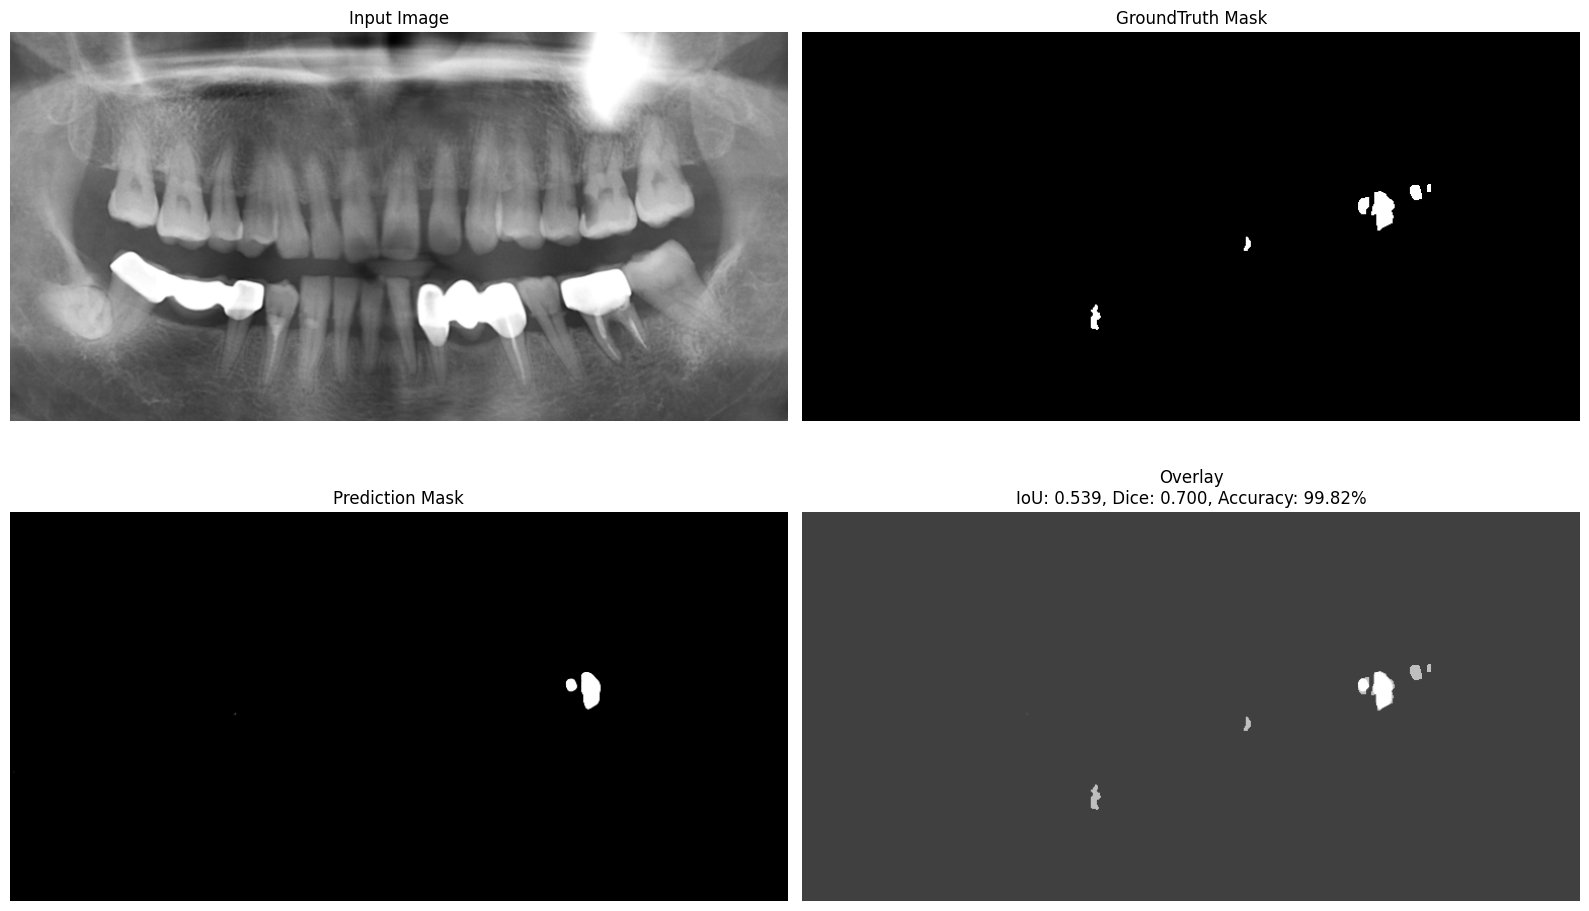

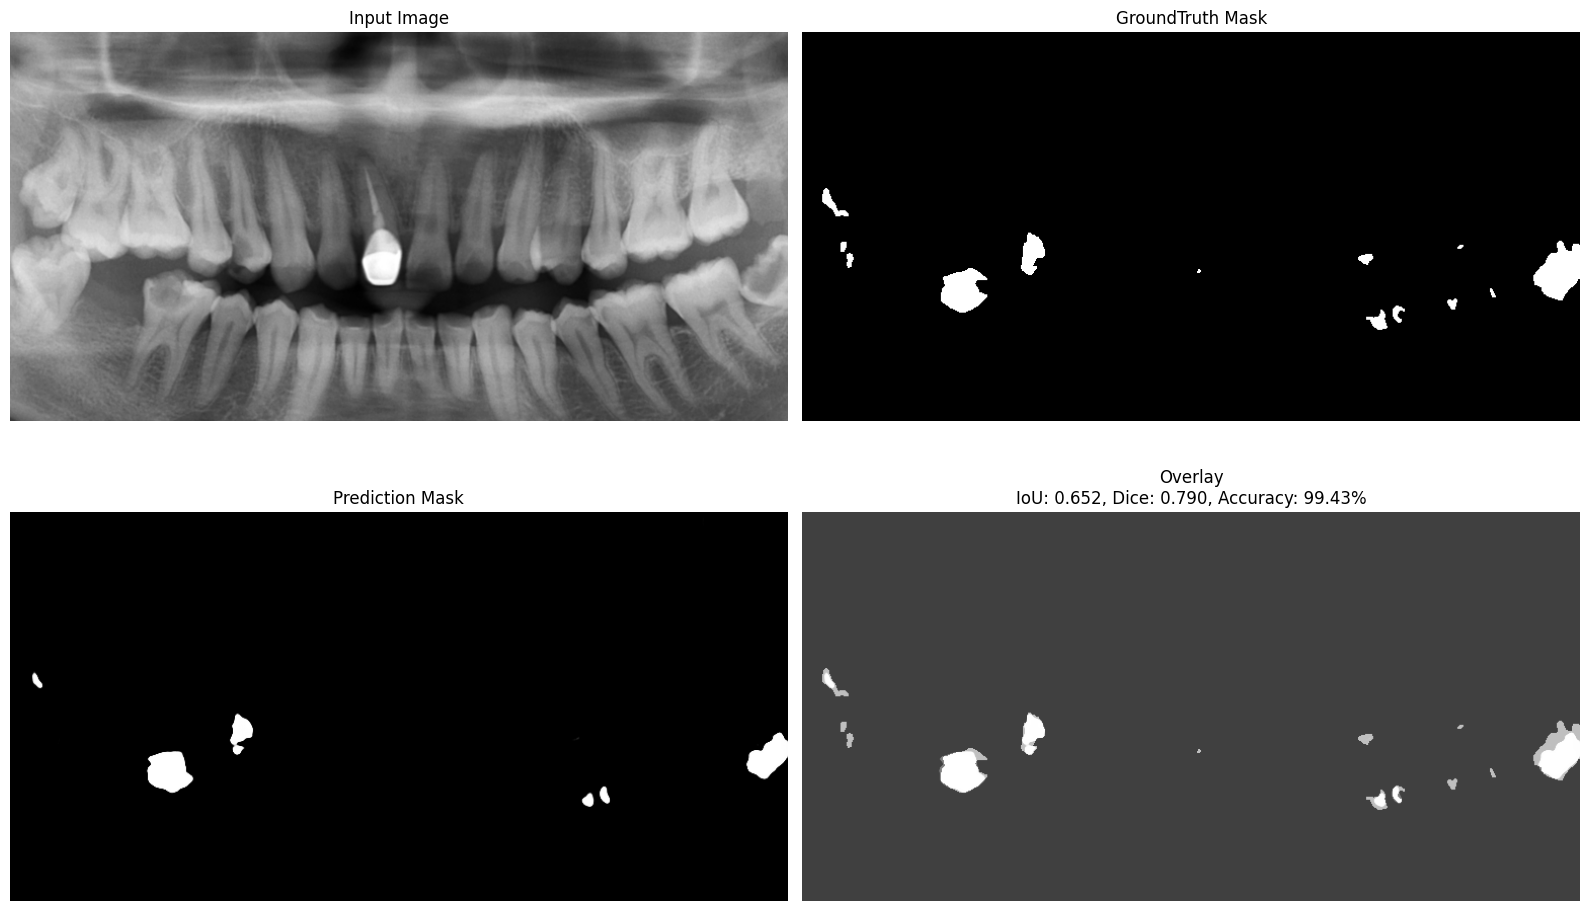

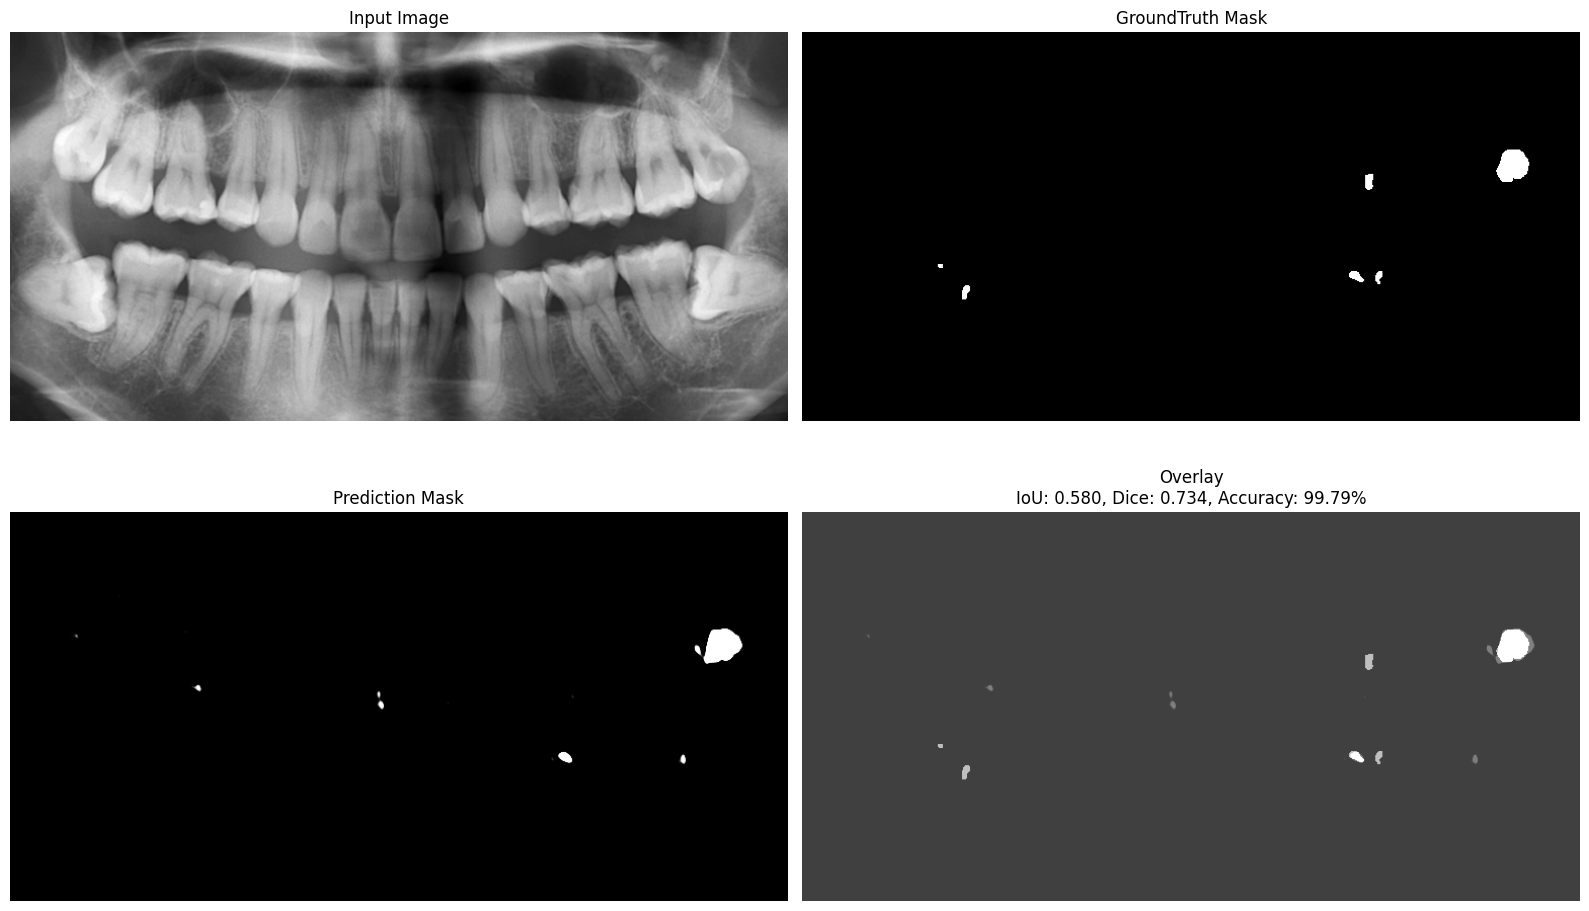

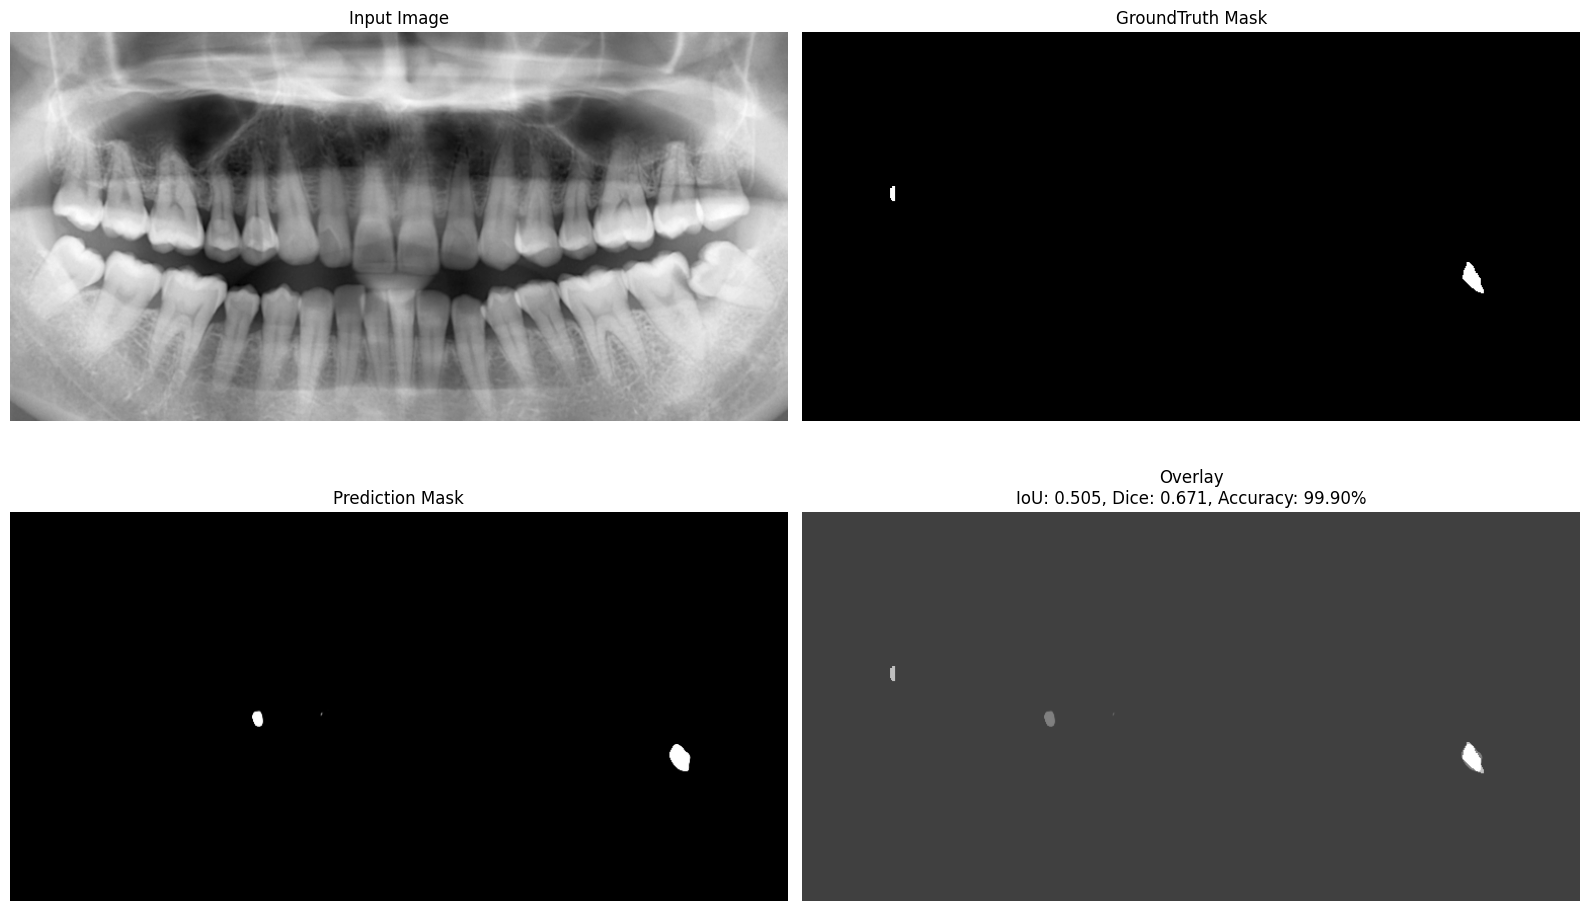

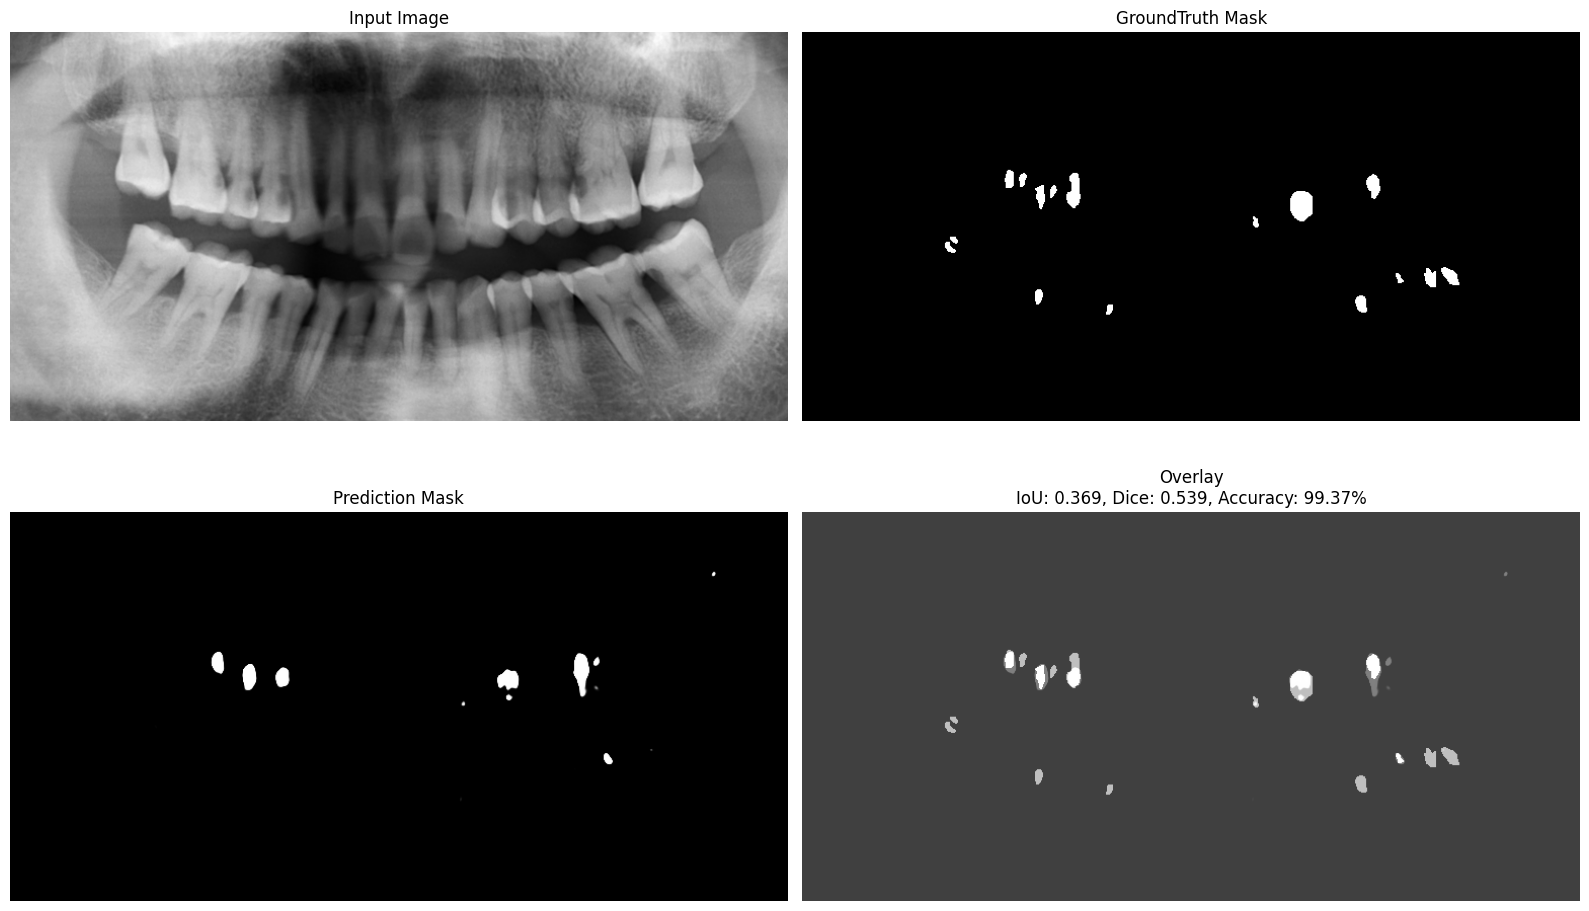

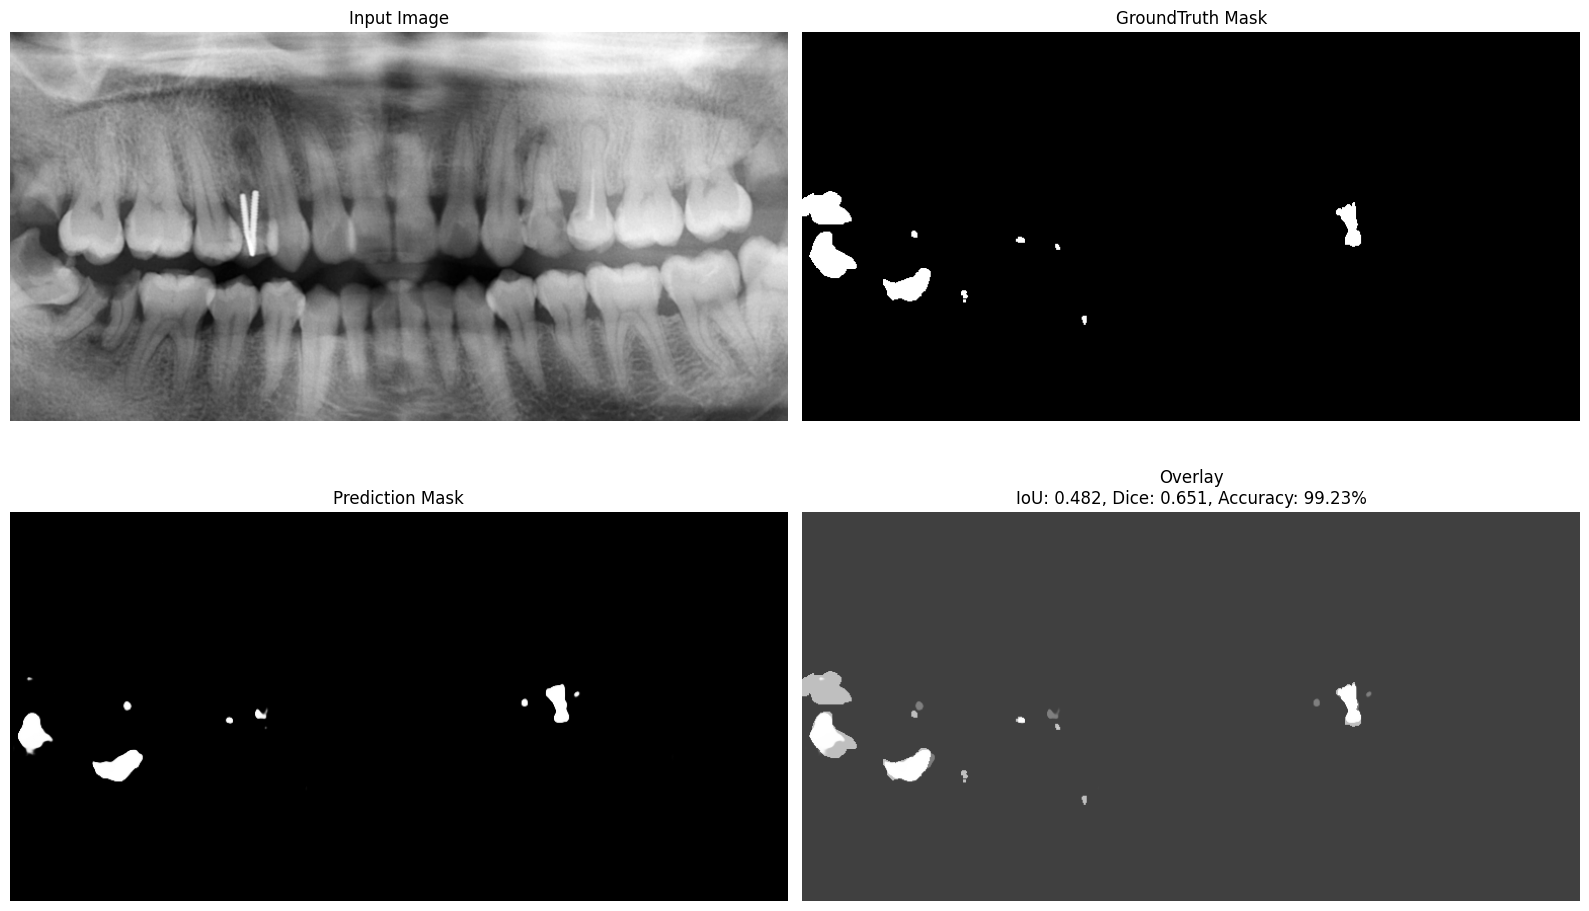

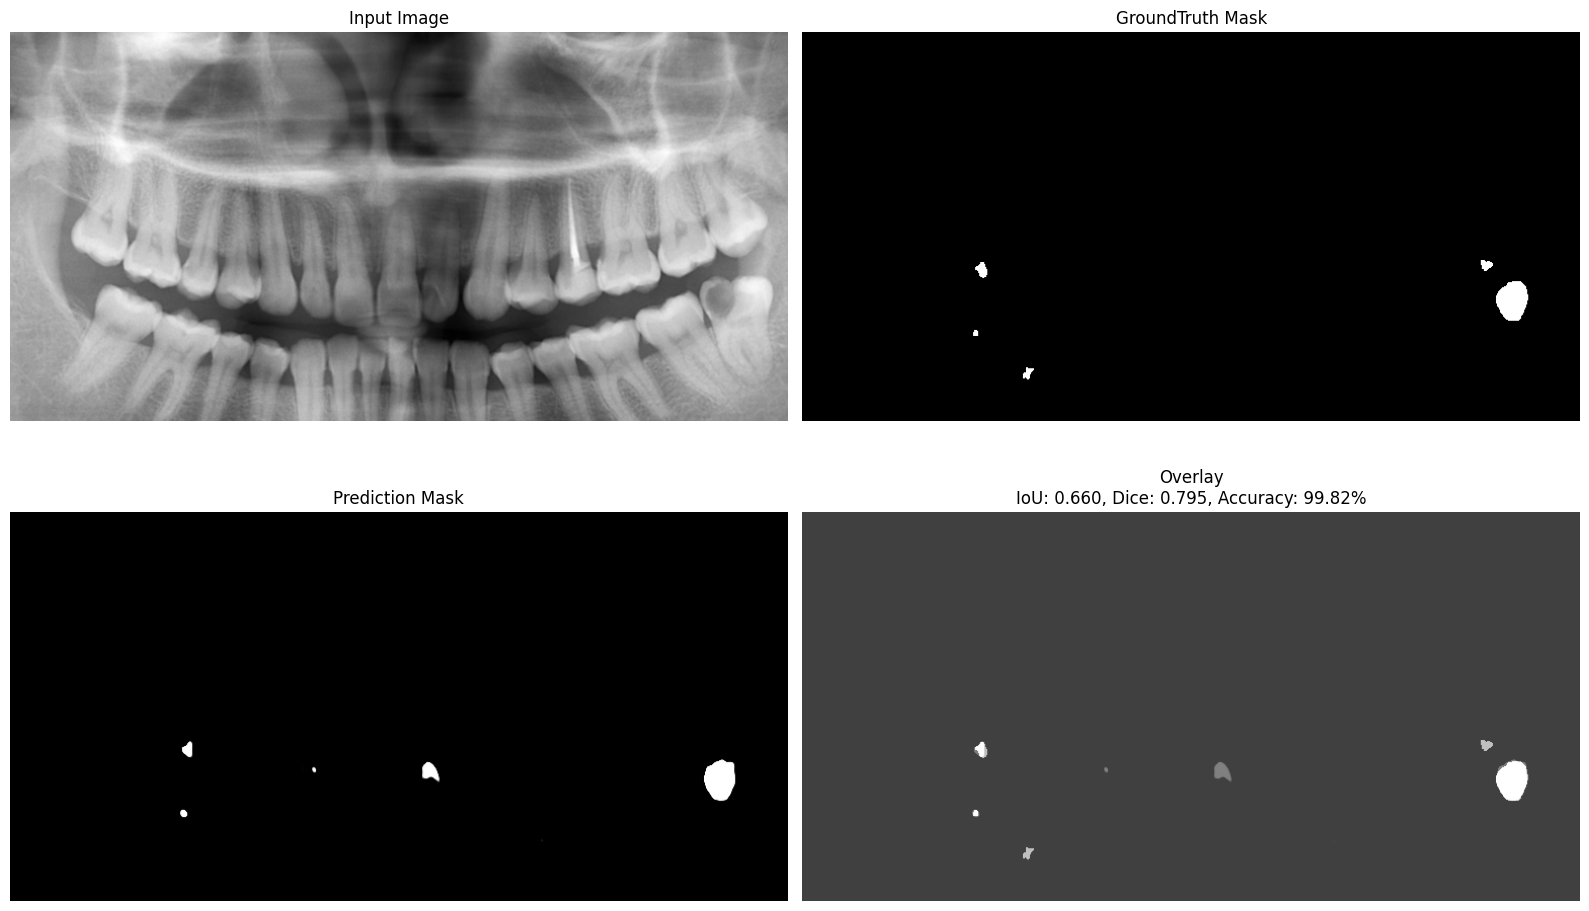

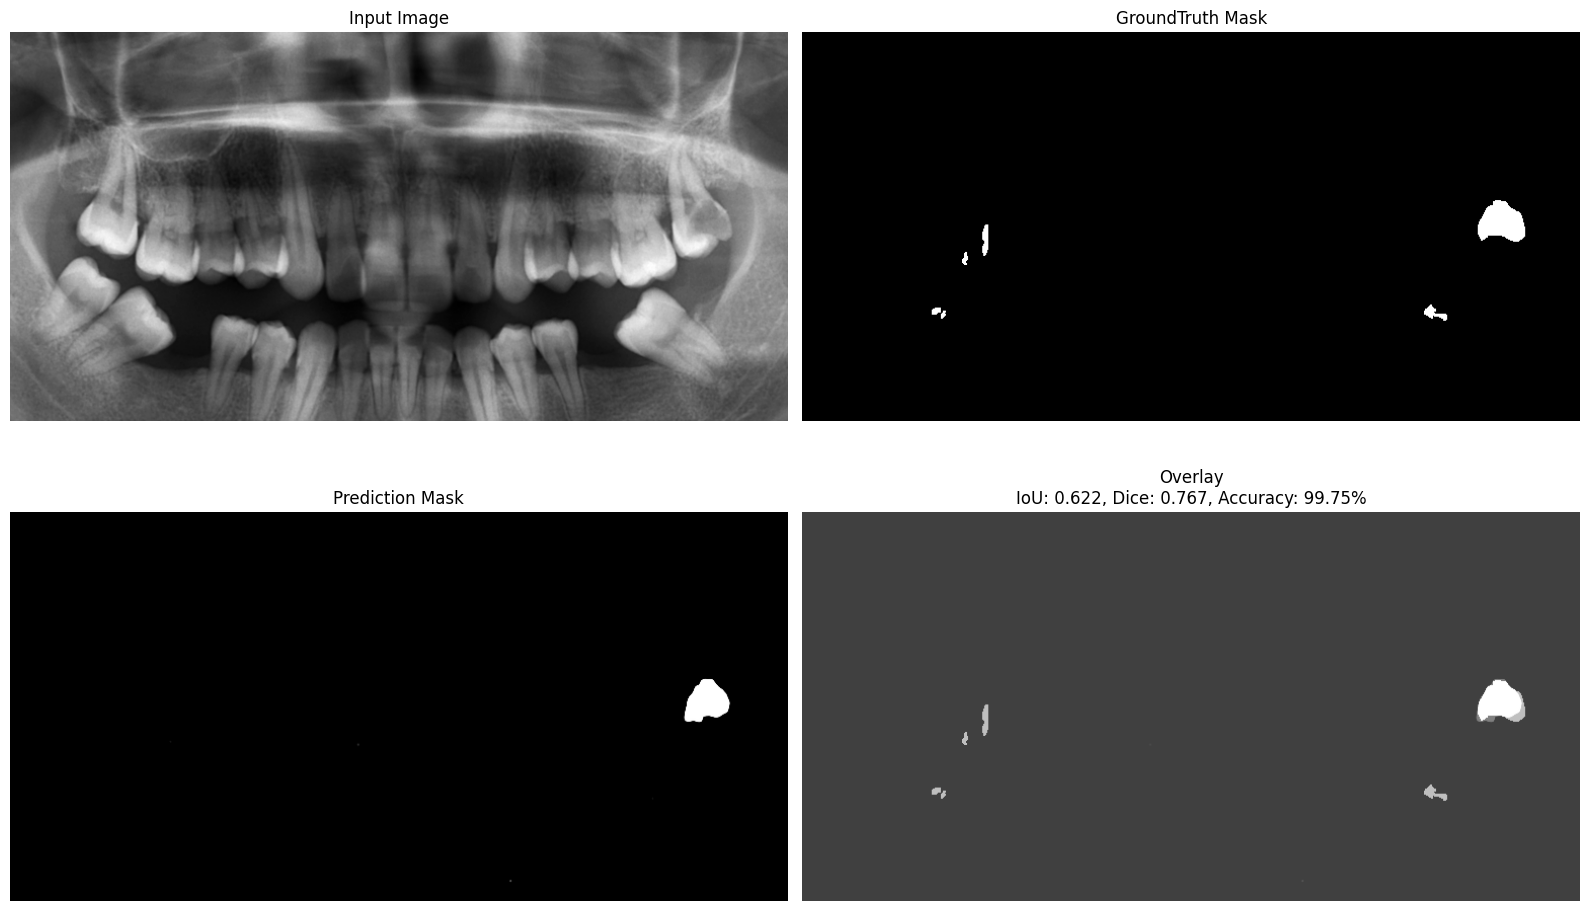

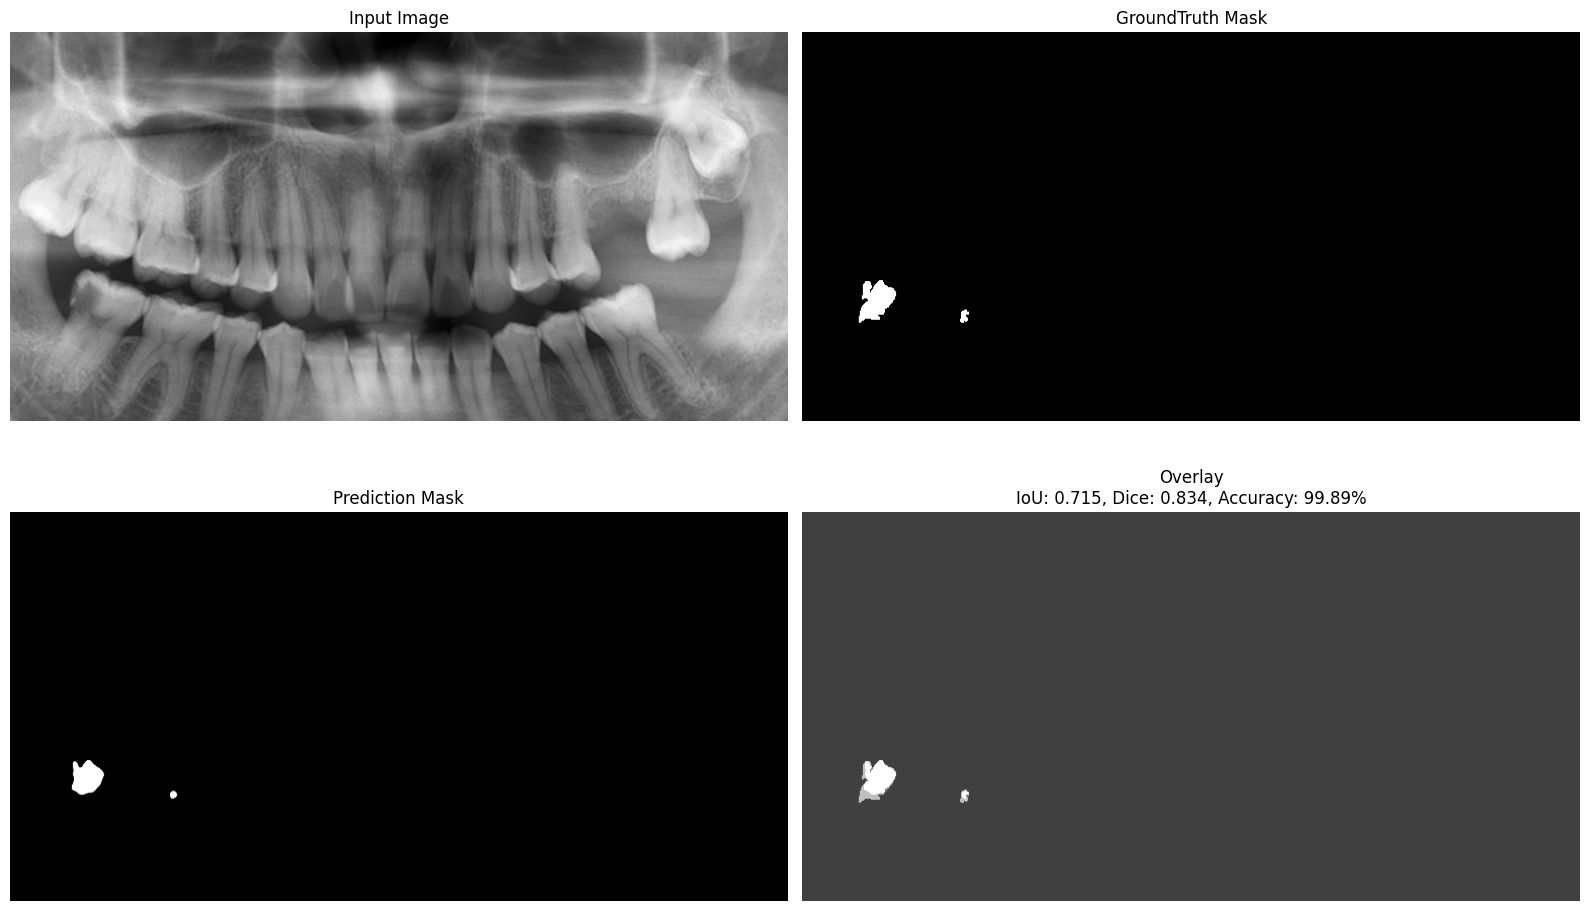

In [ ]:
indices = random.sample(range(len(eval_dataset)), 10)

for idx in indices:
    image, label = eval_dataset[idx]
    with torch.no_grad():
        prediction = model(image.unsqueeze(0))  # [1, 1, H, W]
        probabilities = F.sigmoid(prediction).squeeze(0)  # [1, H, W] → [H, W]

    pred_np = (probabilities > 0.5).cpu().numpy().astype(np.uint8).flatten()
    label_np = label.cpu().numpy().astype(np.uint8).flatten()

    # Вычисление метрик
    TP = np.sum((pred_np == 1) & (label_np == 1))
    FP = np.sum((pred_np == 1) & (label_np == 0))
    FN = np.sum((pred_np == 0) & (label_np == 1))
    TN = np.sum((pred_np == 0) & (label_np == 0))

    iou = TP / (TP + FP + FN + 1e-7)
    dice = 2 * TP / (2 * TP + FP + FN + 1e-7)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-7)

    # Визуализация
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(toPIL(image), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(toPIL(label), cmap='gray')
    plt.title('GroundTruth Mask')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(toPIL(probabilities), cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(toPIL(probabilities), alpha=0.5, cmap='gray')
    plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
    plt.title(f'Overlay\nIoU: {iou:.3f}, Dice: {dice:.3f}, Accuracy: {accuracy*100:.2f}%')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


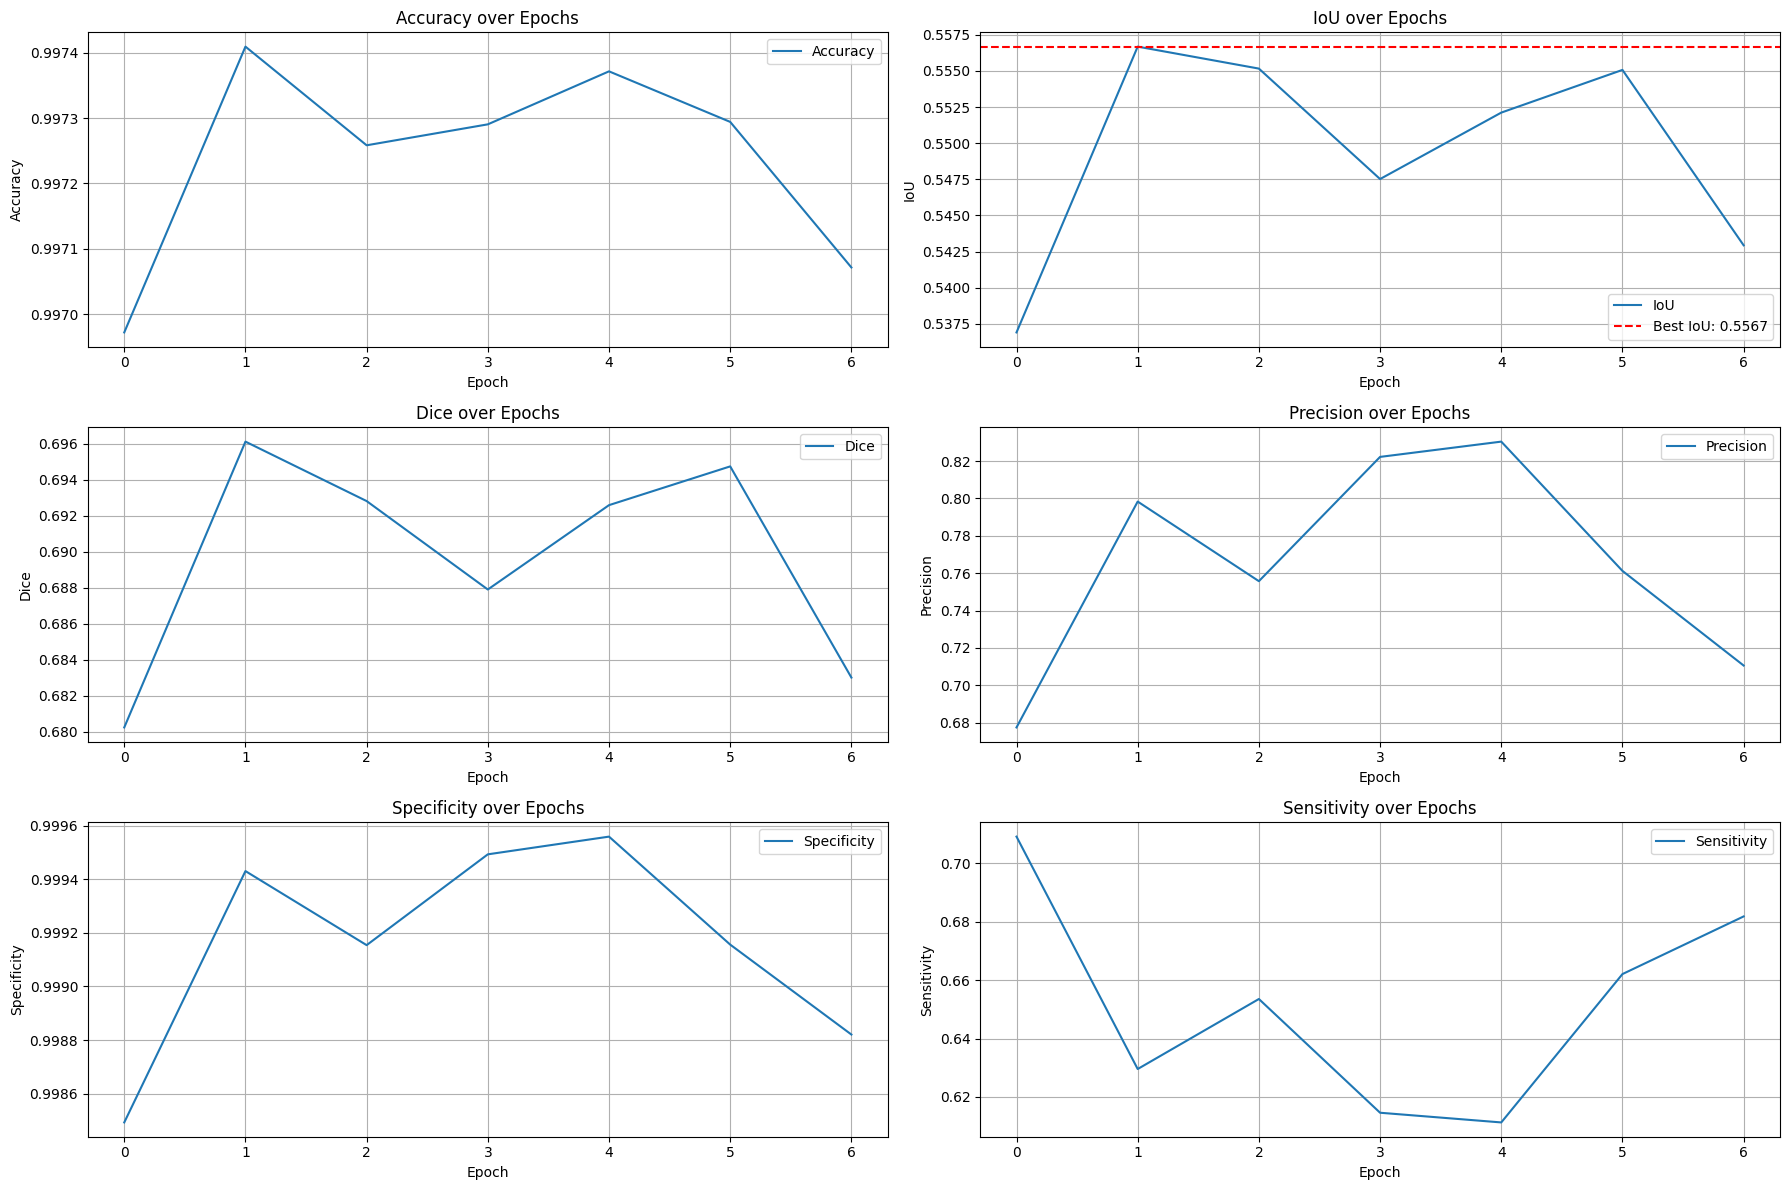

In [ ]:
# Визуализация истории обучения — расширенный вариант
def plot_extended_history(losses_train, losses_val, metrics, IoU_max):
    metric_names = ['Accuracy', 'IoU', 'Dice', 'Precision', 'Specificity', 'Sensitivity']

    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    axes = axes.flatten()

    for i in range(6):
        axes[i].plot([epoch[i] for epoch in metrics], label=metric_names[i], color='tab:blue')
        if i == 1:
            axes[i].axhline(y=IoU_max, color='red', linestyle='--', label=f'Best IoU: {IoU_max:.4f}')
        axes[i].set_title(f"{metric_names[i]} over Epochs")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric_names[i])
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()
plot_extended_history(losses_train, losses_val, metrics, IoU_max)



In [ ]:
def segment_and_visualize(image_path, model, device='cpu', image_size=(384, 768)):
    from torchvision.transforms.functional import to_pil_image

    # Подготовка трансформации
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    # Загрузка и предобработка изображения
    image = Image.open(image_path)
    image_transformed = transform(image).unsqueeze(0).to(device)

    # Предсказание
    model.eval()
    with torch.no_grad():
        prediction = model(image_transformed)
        probability_map = torch.sigmoid(prediction.squeeze(0)).cpu()

    # Расчёт средней вероятности кариозного поражения
    probability_value = probability_map.numpy().mean() * 100

    # Преобразование в изображения
    input_image = to_pil_image(image_transformed.squeeze(0).cpu())
    pred_mask = to_pil_image(probability_map)

    # Визуализация
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title(f"Predicted Mask\nMean Prob: {probability_value:.2f}%")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(input_image, cmap='gray')
    plt.imshow(pred_mask, alpha=0.5, cmap='Reds')
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


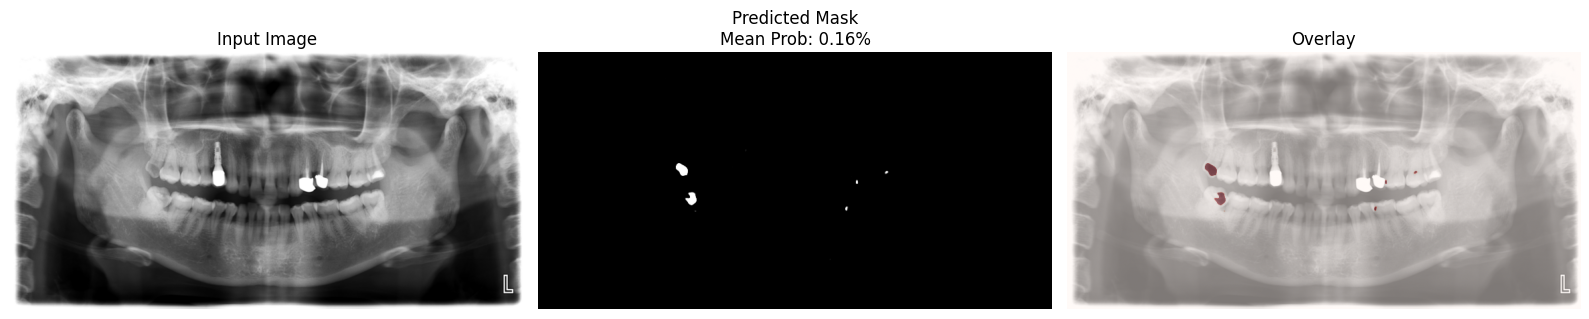

In [ ]:
segment_and_visualize('/content/drive/MyDrive/Диплом/dataset/images/784.png', model, device)

In [ ]:
def full_segmentation_visualization(
    image=None,
    label=None,
    image_path=None,
    model=None,
    device='cpu',
    image_size=(384, 768),
    threshold=0.5,
    show_metrics=True
):
    from torchvision.transforms.functional import to_pil_image

    assert model is not None, "Model must be provided"

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    # Загрузка изображения, если путь указан
    if image_path:
        image_pil = Image.open(image_path)
        image = transform(image_pil).to(device)
        label = None
    else:
        image = image.to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(image.unsqueeze(0))
        probability_map = torch.sigmoid(prediction.squeeze(0)).cpu()

    pred_mask = to_pil_image(probability_map)
    input_image = to_pil_image(image.cpu())
    probability_value = probability_map.numpy().mean() * 100

    # Подсчёт метрик, если есть метка
    if label is not None:
        label_np = label.cpu().numpy().astype(np.uint8).flatten()
        pred_np = (probability_map > threshold).numpy().astype(np.uint8).flatten()

        TP = np.sum((pred_np == 1) & (label_np == 1))
        FP = np.sum((pred_np == 1) & (label_np == 0))
        FN = np.sum((pred_np == 0) & (label_np == 1))
        TN = np.sum((pred_np == 0) & (label_np == 0))

        iou = TP / (TP + FP + FN + 1e-7)
        dice = 2 * TP / (2 * TP + FP + FN + 1e-7)
        accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-7)
    else:
        iou = dice = accuracy = None

    # Визуализация
    plt.figure(figsize=(16, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    if label is not None:
        plt.subplot(2, 2, 2)
        plt.imshow(to_pil_image(label.cpu()), cmap='gray')
        plt.title("GroundTruth Mask")
        plt.axis('off')
    else:
        plt.subplot(2, 2, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f"Prediction (Mean Prob: {probability_value:.2f}%)")
        plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(input_image, cmap='gray')
    plt.imshow(pred_mask, alpha=0.5, cmap='Reds')
    if show_metrics and label is not None:
        plt.title(f"Overlay\nIoU: {iou:.3f}, Dice: {dice:.3f}, Accuracy: {accuracy*100:.2f}%")
    else:
        plt.title(f"Overlay\nMean Prob: {probability_value:.2f}%")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

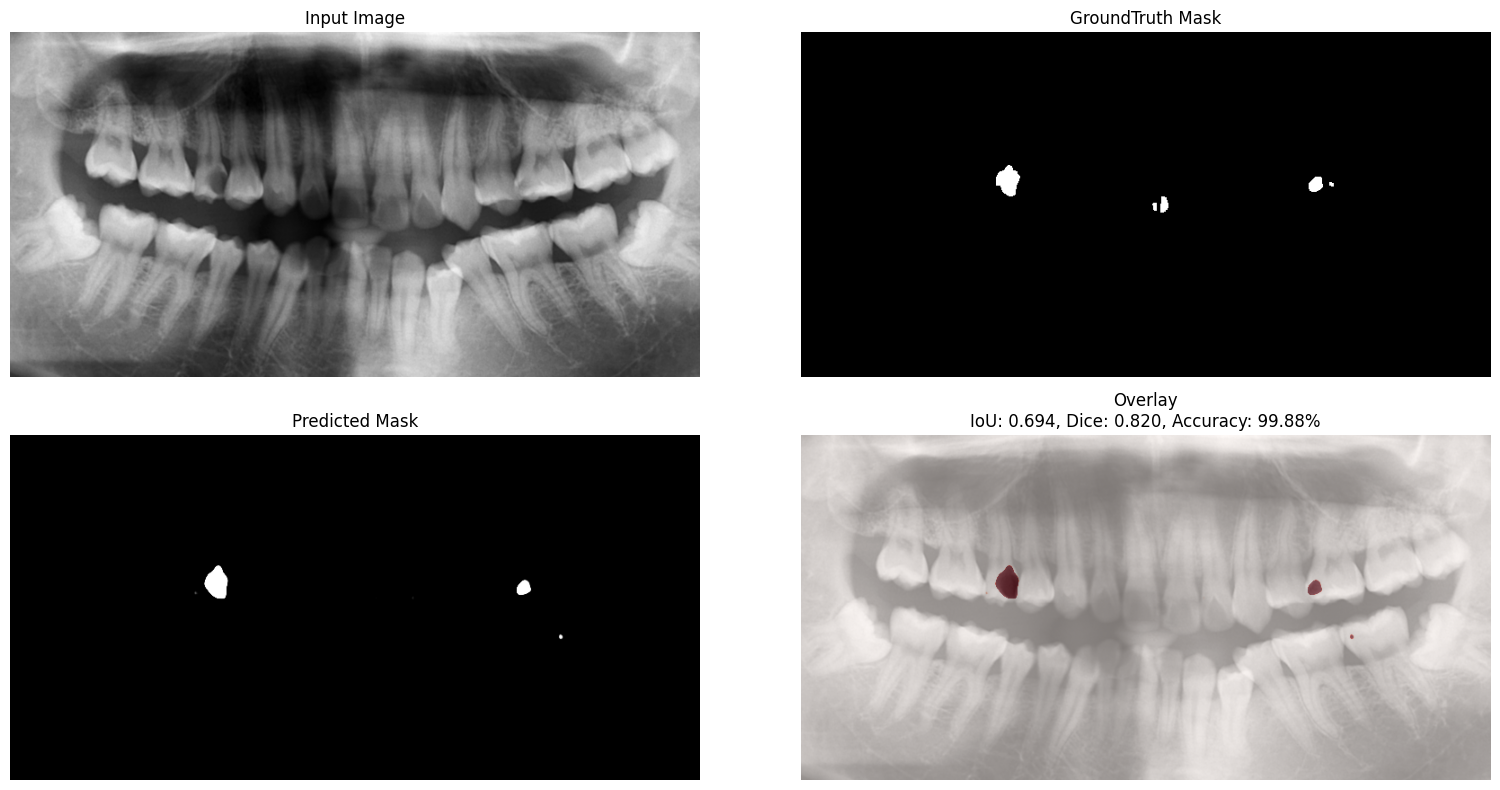

In [ ]:
image, label = eval_dataset[9]
full_segmentation_visualization(image=image, label=label, model=model, device=device)